In [2]:
import csv
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import pandas_datareader.data as web
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from matplotlib import pyplot
import scipy.stats
from statsmodels.tsa.stattools import adfuller
from yahoofinancials import YahooFinancials
from statsmodels.tsa.ar_model import AR
%matplotlib inline

In [3]:
fpath = 'facebook_data_nytimes_comments_sentiment_4dict.tsv'
post_data = pd.read_csv(fpath, sep='\t')
post_data.head()

,ID,PostID,PostDate,CommentID,CommentDate,CommenterURL,CommentText,WNPositive,WNNegative,WNNeutral,...,HVTokenQnt,HVSentiAvg,LMPositive,LMNegative,LMTokenQnt,LMSentiAvg,Vader_Positive,Vader_Negative,Vader_Neutral,Vader_Compound
0,0,1.015271e+16,2021-06-13 14:39:05.828562,10152706166884999,2021-06-13 14:39:39.092970,jessica.mulcahy.5?fref=nf&rc=p&refid=52&__tn__=R,Isn't it a wonder that a company could theoret...,0.750000,1.000000,12.250000,...,23,0.304348,1,1,23,0.000000,0.184,0.137,0.678,0.2960
1,1,1.015271e+16,2021-06-13 14:39:05.828562,10152706181999999,2021-06-13 15:39:39.494895,profile.php?id=100010824877389&fref=nf&rc=p&r...,Not where I live. This information would be in...,1.125000,2.625000,40.250000,...,45,0.066667,2,2,45,0.000000,0.042,0.080,0.878,-0.6588
2,2,1.015271e+16,2021-06-13 14:39:05.828562,10152706167109999,2021-06-13 14:39:39.936749,austin.given?fref=nf&rc=p&refid=52&__tn__=R,Investing is better than renting. Always.,0.875000,0.000000,0.125000,...,3,0.333333,1,0,3,0.333333,0.367,0.000,0.633,0.4404
3,3,1.015271e+16,2021-06-13 14:39:05.828562,10152706182414999,2021-06-13 15:39:40.326378,jessica.vanliere?fref=nf&rc=p&refid=52&__tn__=R,"A house 🏠 is a liability, not an asset. The pe...",7.233696,2.418478,46.347826,...,59,-0.016949,2,1,59,0.016949,0.142,0.045,0.813,0.9459
4,4,1.015271e+16,2021-06-13 14:39:05.828562,10152706185829999,2021-06-13 15:39:40.719285,laura.celidonio?fref=nf&rc=p&refid=52&__tn__=R,Maybe for the big cities of the world. These m...,2.875000,2.000000,23.125000,...,27,0.259259,1,0,27,0.037037,0.096,0.025,0.879,0.7469


In [4]:
post_data['Vader_Average'] = post_data['Vader_Positive'] - post_data['Vader_Negative']

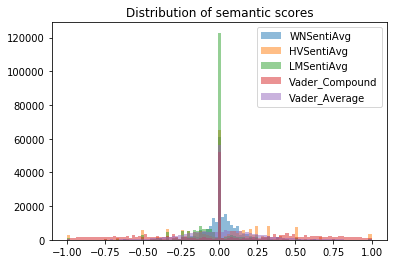

In [5]:
bins = np.linspace(-1, 1, 100)
pyplot.hist(post_data['WNSentiAvg'], bins, alpha=0.5, label='WNSentiAvg')
pyplot.hist(post_data['HVSentiAvg'], bins, alpha=0.5, label='HVSentiAvg')
pyplot.hist(post_data['LMSentiAvg'], bins, alpha=0.5, label='LMSentiAvg')
pyplot.hist(post_data['Vader_Compound'], bins, alpha=0.5, label='Vader_Compound')
pyplot.hist(post_data['Vader_Positive'] - post_data['Vader_Negative'], bins, alpha=0.5, label='Vader_Average')
pyplot.legend(loc='upper right')
pyplot.title('Distribution of semantic scores')
pyplot.show()

Text(0, 0.5, 'Posts')

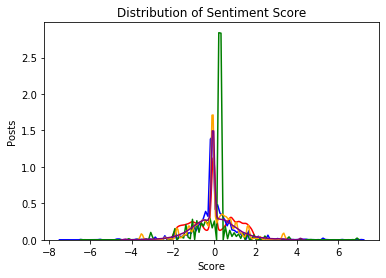

In [6]:


# seaborn histogram
sns.distplot((post_data['Vader_Compound'] - post_data['Vader_Compound'].mean())/post_data['Vader_Compound'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'red',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['WNSentiAvg'] - post_data['WNSentiAvg'].mean())/post_data['WNSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['LMSentiAvg'] - post_data['LMSentiAvg'].mean())/post_data['LMSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'green',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['HVSentiAvg'] - post_data['HVSentiAvg'].mean())/post_data['HVSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'orange',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['Vader_Average'] - post_data['Vader_Average'].mean())/post_data['Vader_Average'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'purple',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Distribution of Sentiment Score')
plt.xlabel('Score')
plt.ylabel('Posts')

In [7]:
post_data[['WNSentiAvg','HVSentiAvg','LMSentiAvg','Vader_Compound','Vader_Average']].describe()

,WNSentiAvg,HVSentiAvg,LMSentiAvg,Vader_Compound,Vader_Average
count,214602.000000,214602.000000,214602.000000,214602.000000,214602.000000
mean,0.018138,0.024849,-0.040729,0.022084,0.015085
std,0.138283,0.291396,0.150766,0.507221,0.235637
min,-1.000000,-1.000000,-1.000000,-0.999700,-1.000000
25%,-0.028846,-0.105263,-0.083333,-0.373600,-0.097000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.062500,0.166667,0.000000,0.440400,0.127000
max,1.000000,1.000000,1.000000,0.999700,1.000000


In [8]:
post_data['PostDate'] = pd.to_datetime(post_data['PostDate'], errors='coerce')

post_data['DateMonth'] = post_data['PostDate'].dt.strftime('%Y-%m')
post_data['DateDay'] = post_data['PostDate'].dt.strftime('%Y-%m-%d')

In [9]:
post_data['DateMonth'].head()

0    2021-06
1    2021-06
2    2021-06
3    2021-06
4    2021-06
Name: DateMonth, dtype: object

In [10]:
post_data.columns

Index(['ID', 'PostID', 'PostDate', 'CommentID', 'CommentDate', 'CommenterURL',
       'CommentText', 'WNPositive', 'WNNegative', 'WNNeutral', 'WNSentiment',
       'WNTokenQnt', 'WNSentiAvg', 'HVPositive', 'HVNegative', 'HVTokenQnt',
       'HVSentiAvg', 'LMPositive', 'LMNegative', 'LMTokenQnt', 'LMSentiAvg',
       'Vader_Positive', 'Vader_Negative', 'Vader_Neutral', 'Vader_Compound',
       'Vader_Average', 'DateMonth', 'DateDay'],
      dtype='object')

In [11]:
Monthly_Data = post_data.groupby('DateMonth').agg({'WNSentiAvg': 'sum'
                                                         ,'WNTokenQnt':'count'
                                                        ,'Vader_Compound':'mean'
                                                        ,'Vader_Average': 'mean'
                                                        ,'HVPositive':'sum'
                                                        ,'HVNegative':'sum'
                                                        ,'HVTokenQnt':'sum'
                                                        ,'LMPositive':'sum'
                                                        ,'LMNegative':'sum'
                                                        ,'LMTokenQnt':'sum'
                                                       })

In [12]:
DailyData = post_data.groupby('DateDay').agg({'WNSentiAvg': 'sum'
                                                        ,'WNTokenQnt':'count'
                                                        ,'Vader_Compound':'mean'
                                                        ,'Vader_Average': 'mean'
                                                        ,'HVPositive':'sum'
                                                        ,'HVNegative':'sum'
                                                        ,'HVTokenQnt':'sum'
                                                        ,'LMPositive':'sum'
                                                        ,'LMNegative':'sum'
                                                        ,'LMTokenQnt':'sum'
                                                        })

In [13]:
DailyData['WNSentiment'] =  DailyData['WNSentiAvg']/ DailyData['WNTokenQnt']
DailyData['HVSentiment'] = (DailyData['HVPositive'] - DailyData['HVNegative'])/DailyData['HVTokenQnt']
DailyData['LMSentiment'] = (DailyData['LMPositive'] - DailyData['LMNegative'])/DailyData['LMTokenQnt']

Monthly_Data['WNSentiment'] =  Monthly_Data['WNSentiAvg']/ Monthly_Data['WNTokenQnt']
Monthly_Data['HVSentiment'] = (Monthly_Data['HVPositive'] - Monthly_Data['HVNegative'])/Monthly_Data['HVTokenQnt']
Monthly_Data['LMSentiment'] = (Monthly_Data['LMPositive'] - Monthly_Data['LMNegative'])/Monthly_Data['LMTokenQnt']



In [14]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['WNSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -3.0102
p-value                          0.0340
#Lags Used                       6.0000
Number of Observations Used    209.0000
Critical Value (1%)             -3.4620
Critical Value (5%)             -2.8755
Critical Value (10%)            -2.5742
dtype: float64


In [15]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['HVSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -10.0990
p-value                          0.0000
#Lags Used                       0.0000
Number of Observations Used    215.0000
Critical Value (1%)             -3.4611
Critical Value (5%)             -2.8751
Critical Value (10%)            -2.5740
dtype: float64


In [16]:
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['LMSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value


Test Statistic                 -10.0990
p-value                          0.0000
#Lags Used                       0.0000
Number of Observations Used    215.0000
Critical Value (1%)             -3.4611
Critical Value (5%)             -2.8751
Critical Value (10%)            -2.5740
dtype: float64
Results of Dickey-Fuller Test:


In [17]:
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['Vader_Compound'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value


Test Statistic                  -2.9641
p-value                          0.0384
#Lags Used                       8.0000
Number of Observations Used    207.0000
Critical Value (1%)             -3.4623
Critical Value (5%)             -2.8756
Critical Value (10%)            -2.5743
dtype: float64
Results of Dickey-Fuller Test:


In [18]:
DailyData.head()

,WNSentiAvg,WNTokenQnt,Vader_Compound,Vader_Average,HVPositive,HVNegative,HVTokenQnt,LMPositive,LMNegative,LMTokenQnt,WNSentiment,HVSentiment,LMSentiment
DateDay,,,,,,,,,,,,,
2015-09-13,4.601582,115,0.154141,0.116713,248,173,1763,43,57,1763,0.040014,0.042541,-0.007941
2019-09-29,10.168065,743,0.038492,0.035493,1322,1096,6848,154,544,6848,0.013685,0.033002,-0.056951
2019-09-30,1.812409,57,-0.090011,-0.026298,201,197,1143,25,107,1143,0.031797,0.003500,-0.071741
2019-11-29,2.517020,145,-0.016368,-0.015338,218,148,1219,25,56,1219,0.017359,0.057424,-0.025431
2019-11-30,16.443055,905,0.072205,0.040280,1229,846,6674,183,380,6674,0.018169,0.057387,-0.029518


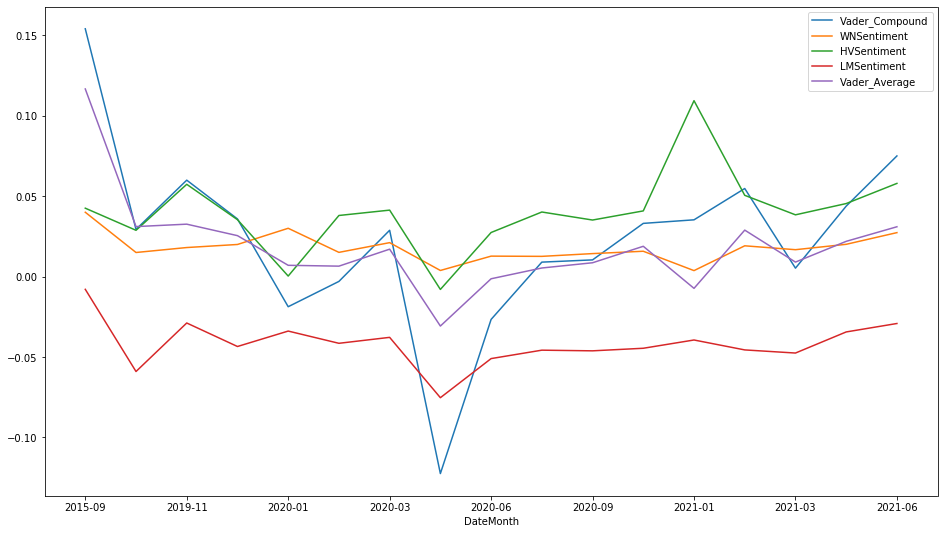

In [19]:
Monthly_Data[['Vader_Compound','WNSentiment','HVSentiment','LMSentiment','Vader_Average']].plot(legend=True, figsize=(16,9))

## Download S&P from Yahoo

In [20]:
#SnP_daily = web.get_data_yahoo('^GSPC','10/01/2010','05/01/2021',interval='d')
#SnP_monthly = web.get_data_yahoo('^GSPC','10/01/2010','05/01/2021',interval='m')
yahoo_financials = YahooFinancials(['^GSPC']).get_historical_price_data('2019-01-01','2021-05-31','daily')
SnP_daily =pd.DataFrame(yahoo_financials["^GSPC"]["prices"])
SnP_daily.index = SnP_daily['formatted_date']
SnP_daily['LogReturn'] = np.log(SnP_daily['adjclose']/SnP_daily['adjclose'].shift(1))

yahoo_financials_m = YahooFinancials(['^GSPC']).get_historical_price_data('2019-01-01','2021-05-31','monthly')
SnP_monthly =pd.DataFrame(yahoo_financials_m["^GSPC"]["prices"])
SnP_monthly.index = SnP_monthly['formatted_date']
SnP_monthly['LogReturn'] = np.log(SnP_monthly['adjclose']/SnP_monthly['adjclose'].shift(1))


In [20]:
SnP_daily['LogReturn'] = np.log(SnP_daily['Adj Close']/SnP_daily['Adj Close'].shift(1))

In [21]:
SnP_monthly.index = SnP_monthly.index.strftime('%Y-%m')

AttributeError: 'Index' object has no attribute 'strftime'

In [22]:
SnP_monthly['LogReturn'] = np.log(SnP_monthly['Adj Close']/SnP_monthly['Adj Close'].shift(1))

## Granger test

In [22]:
Granger_data_daily = pd.merge(SnP_daily,DailyData, how= 'inner', left_index=True, right_index=True)

In [23]:
def grangerTest(exog, endog):
    MAX_LAG = 30
    ARaic = AR(exog.tolist()).fit(maxlag=MAX_LAG, ic="aic")
    ARbic = AR(exog.tolist()).fit(maxlag=MAX_LAG, ic="bic")
    # select the fewer number of parameters between both criteria.
    numExog = len(ARaic.params) if len(ARaic.params) < len(ARbic.params) else len(ARbic.params)

    print ("Optimal number of lags for exog data is " + str(numExog))

    ARaic = AR(endog.tolist()).fit(maxlag=MAX_LAG, ic="aic")
    ARbic = AR(endog.tolist()).fit(maxlag=MAX_LAG, ic="bic")
    # select the fewer number of parameters between both criteria.
    numEndog = len(ARaic.params) if len(ARaic.params) < len(ARbic.params) else len(ARbic.params)

    print ("Optimal number of lags for endog data is " + str(numEndog))

    # now that I know the optimal number of parameters, I can call the
    # granger causality function of statsmodels.
    data = pd.concat([endog, exog], axis=1)
    print ("\nGranger causality results of indep onto dep")
    results = grangercausalitytests(data, maxlag=numEndog)

    data = pd.concat([exog, endog], axis=1)
    print ("\nGranger causality results of dep onto indep")
    results = grangercausalitytests(data, maxlag=numExog)
    regr = results[2][1]
    print (regr[0].params)
    print (regr[1].params)
    print (regr[1].pvalues)

In [25]:
Granger_data_monthly = pd.merge(SnP_monthly,Monthly_Data, how= 'inner', left_index=True, right_index=True)

In [26]:
#Granger_data['SS_LogReturn'] = np.log((Granger_data['SentimentScoreAdj']+1)/(Granger_data['SentimentScoreAdj']+1).shift(1))

In [27]:
Granger_data_monthly

,High,Low,Open,Close,Volume,Adj Close,LogReturn,WNSentiAvg,WNTokenQnt,Vader_Compound,Vader_Average,HVPositive,HVNegative,HVTokenQnt,LMPositive,LMNegative,LMTokenQnt,WNSentiment,HVSentiment,LMSentiment
2011-06,1345.199951,1258.069946,1345.199951,1320.640015,86122730000,1320.640015,-0.018426,0.000000,1,-0.631000,-0.165000,0,1,8,0,1,8,0.000000,-0.125000,-0.125000
2011-07,1356.479980,1282.859985,1320.640015,1292.280029,81102170000,1292.280029,-0.021708,0.057692,2,0.484350,0.124500,5,0,26,0,0,26,0.028846,0.192308,0.000000
2011-08,1307.380005,1101.540039,1292.589966,1218.890015,108419170000,1218.890015,-0.058468,0.102652,7,0.298771,0.235571,16,5,51,1,0,51,0.014665,0.215686,0.019608
2011-09,1229.290039,1114.219971,1219.119995,1131.420044,102786820000,1131.420044,-0.074467,-0.062500,5,-0.160040,-0.090800,0,6,18,0,5,18,-0.012500,-0.333333,-0.277778
2011-10,1292.660034,1074.770020,1131.209961,1253.300049,98063670000,1253.300049,0.102307,0.053971,10,0.251150,0.100300,21,9,83,3,6,83,0.005397,0.144578,-0.036145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01,3870.899902,3662.709961,3764.610107,3714.239990,105548790000,3714.239990,-0.011199,76.404470,2123,0.106775,0.047973,3653,2259,19638,603,999,19638,0.035989,0.070985,-0.020165
2021-02,3950.429932,3725.620117,3731.169922,3811.149902,98596960000,3811.149902,0.025757,35.554546,1008,0.104644,0.036783,1739,846,9117,282,399,9117,0.035272,0.097949,-0.012833
2021-03,3994.409912,3723.340088,3842.510010,3972.889893,120863560000,3972.889893,0.041563,50.886415,1283,0.160192,0.072603,2566,1455,13705,413,628,13705,0.039662,0.081065,-0.015688
2021-04,4218.779785,3992.780029,3992.780029,4181.169922,82869290000,4181.169922,0.051097,31.388089,946,0.111396,0.041881,1853,1109,10004,321,498,10004,0.033180,0.074370,-0.017693


In [24]:
Vars = ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"]
for Var in Vars:
    print("\n" + Var + "\n")
    grangerTest(Granger_data_daily[Var], Granger_data_daily['LogReturn'])


Vader_Compound

Optimal number of lags for exog data is 2
Optimal number of lags for endog data is 2

Granger causality results of indep onto dep

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3491  , p=0.2475  , df_denom=134, df_num=1
ssr based chi2 test:   chi2=1.3793  , p=0.2402  , df=1
likelihood ratio test: chi2=1.3724  , p=0.2414  , df=1
parameter F test:         F=1.3491  , p=0.2475  , df_denom=134, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9793  , p=0.1423  , df_denom=131, df_num=2
ssr based chi2 test:   chi2=4.1097  , p=0.1281  , df=2
likelihood ratio test: chi2=4.0488  , p=0.1321  , df=2
parameter F test:         F=1.9793  , p=0.1423  , df_denom=131, df_num=2

Granger causality results of dep onto indep

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6560  , p=0.4194  , df_denom=134, df_num=1
ssr based chi2 test:   chi2=0.6707  , p=0.4128  , df=1
likelihood ratio test: chi2=0.

C:\Users\Windows\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)


Optimal number of lags for exog data is 2
Optimal number of lags for endog data is 2

Granger causality results of indep onto dep

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8342  , p=0.1779  , df_denom=134, df_num=1
ssr based chi2 test:   chi2=1.8752  , p=0.1709  , df=1
likelihood ratio test: chi2=1.8625  , p=0.1723  , df=1
parameter F test:         F=1.8342  , p=0.1779  , df_denom=134, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2481  , p=0.2904  , df_denom=131, df_num=2
ssr based chi2 test:   chi2=2.5915  , p=0.2737  , df=2
likelihood ratio test: chi2=2.5671  , p=0.2771  , df=2
parameter F test:         F=1.2481  , p=0.2904  , df_denom=131, df_num=2

Granger causality results of dep onto indep

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9818  , p=0.3235  , df_denom=134, df_num=1
ssr based chi2 test:   chi2=1.0038  , p=0.3164  , df=1
likelihood ratio test: chi2=1.0002  , p=0.3173 

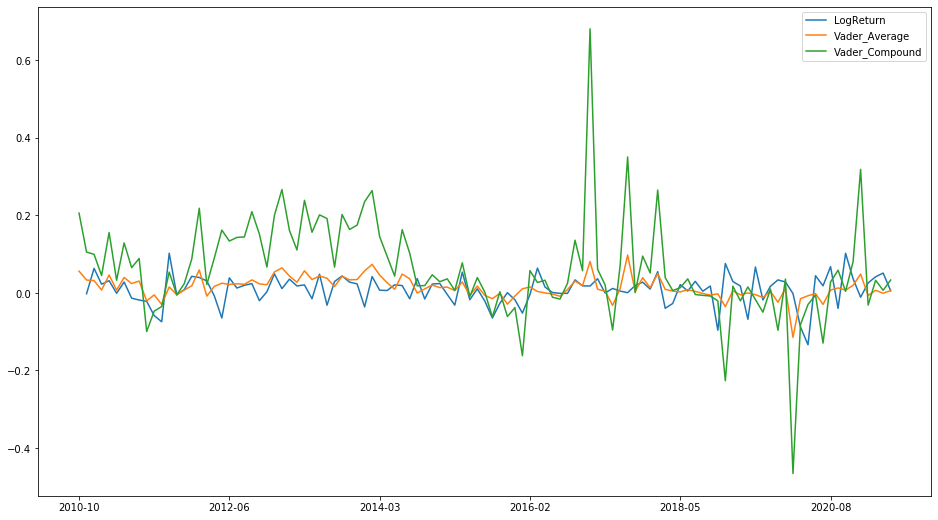

In [33]:
Granger_data_monthly[['LogReturn','Vader_Average','Vader_Compound']].plot(legend=True, figsize=(16,9))

In [25]:
corr = Granger_data_daily[["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment","LogReturn"]].corr()
corr.style.background_gradient(cmap='coolwarm')

,Vader_Compound,Vader_Average,WNSentiment,HVSentiment,LMSentiment,LogReturn
Vader_Compound,1.000000,0.946405,0.677773,0.771421,0.687455,-0.080126
Vader_Average,0.946405,1.000000,0.742499,0.695500,0.609448,-0.092176
WNSentiment,0.677773,0.742499,1.000000,0.581874,0.520041,-0.084890
HVSentiment,0.771421,0.695500,0.581874,1.000000,0.681953,-0.059297
LMSentiment,0.687455,0.609448,0.520041,0.681953,1.000000,-0.158121
LogReturn,-0.080126,-0.092176,-0.084890,-0.059297,-0.158121,1.000000


In [26]:
pvals = [] 
for col in ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"]:
    pvals.append(scipy.stats.linregress(Granger_data_daily['LogReturn'][1:], Granger_data_daily[col][1:].dropna())[3])
corr_signif = pd.DataFrame(pvals,columns = ['p-value']
                           ,index = ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"])
corr_signif

,p-value
Vader_Compound,0.363295
Vader_Average,0.292556
WNSentiment,0.303349
HVSentiment,0.504326
LMSentiment,0.066532


In [38]:
pvals_mnt = [] 
for col in ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average']:
    pvals_mnt.append(scipy.stats.linregress(Granger_data_monthly['LogReturn'][1:], Granger_data_monthly[col][1:].dropna())[3])
corr_signif_mnt = pd.DataFrame(pvals_mnt,columns = ['p-value']
                           ,index = ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average'])
corr_signif_mnt

,p-value
Vader_Compound,0.084306
Flair_Score,0.977764
SentimentScoreAdj,0.311650
Vader_Average,0.047369
